In [1]:
import os
import shutil
os.chdir('..')

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns

sns.set_context("notebook", font_scale=1.4)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

tmp_dir = "tmp_dir"
os.makedirs(tmp_dir, exist_ok=True)

# Evaluation

* The goal of this notebook is to provide an end-to-end example for evaluating recommender algorithms. 
* In the previous [Model Selection Notebook](https://github.com/fidelity/mab2rec/blob/main/notebooks/3_model_selection.ipynb), imagine that we identified a small set of recommenders with good performance.  
* In this notebook, we stress test these top contender algorithms further.  
* For input data, we use the famous [MovieLens 100K Dataset](https://grouplens.org/datasets/movielens/100k/). 
* The goal is not to build the best recommender for MovieLens but to showcase an end-to-end example of training recommenders with detailed evaluations to compare the different approaches.
* For recommendation algorithm, we take advantage of [MABWiser](https://github.com/fidelity/mabwiser) ([IJAIT'21](https://www.worldscientific.com/doi/abs/10.1142/S0218213021500214), [ICTAI'19](https://ieeexplore.ieee.org/document/8995418)) for bandit policies. 
* For performance evaluation, we employ [Jurity](https://github.com/fidelity/jurity) for various metrics.

# Table of Contents
1. [Input Data](#Input-Data)
2. [Recommenders](#Recommenders)
3. [Metrics](#Metrics)
4. [Benchmark](#Benchmark)
5. [Evaluation](#Evaluation)
    1. [Recommendation Metrics](#Recommendation-Metrics)
    2. [Inter-list Diversity Metric](#Inter-list-Diversity-Metric)
    3. [Intra-list Diversity Metric](#Intra-list-Diversity-Metric)
    4. [Recommendation Counts and Ground Truth](#Recommendation-Counts-and-Ground-Truth)
    5. [Recommendation Counts by Item](#Recommendation-Counts-by-Item)
    6. [Personalization Heatmap](#Personalization-Heatmap)
    7. [Fairness Metrics](#Fairness-Metrics)
6. [Train & Export](#Train-&-Export)

# Input Data

* Inut data is as described in [Data Overview](https://github.com/fidelity/mab2rec/blob/main/notebooks/1_data_overview.ipynb).

In [2]:
# Input data
train_data = "data/ml100k/data_train.csv"
test_data = "data/ml100k/data_test.csv"

user_features = "data/ml100k/features_user.csv"
item_features = "data/ml100k/features_item.csv"

# Read data
train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)

user_features_df = pd.read_csv(user_features)
item_features_df = pd.read_csv(item_features)

# Recommenders

* Below we specify **a set of recommenders** to evaluate.
* In practice, we would select a small set of candidate algorithms with [Model Selection](https://github.com/fidelity/mab2rec/blob/main/notebooks/3_model_selection.ipynb).
* As shown in [model selection](https://github.com/fidelity/mab2rec/blob/main/notebooks/3_model_selection.ipynb), we benchmark several algorithms on a **validation dataset** or using **cross validation**. 
* This allows us avoid overfitting on the test data by considering a large number of algorithms repeatedly evaluated on train data.


In [3]:
from mab2rec import BanditRecommender, LearningPolicy, NeighborhoodPolicy

# Set of recommenders
recommenders = {
      "Random": BanditRecommender(learning_policy=LearningPolicy.Random()),
      "LinGreedy": BanditRecommender(learning_policy=LearningPolicy.LinGreedy(epsilon=0.1)),
      "LinTS": BanditRecommender(learning_policy=LearningPolicy.LinTS()),
      "ClustersTS": BanditRecommender(learning_policy=LearningPolicy.ThompsonSampling(), 
                                      neighborhood_policy=NeighborhoodPolicy.Clusters(n_clusters=10)),
      "LinUCB": BanditRecommender(learning_policy=LearningPolicy.LinUCB(alpha=1.0))
}

recommenders

{'Random': <mab2rec.rec.BanditRecommender at 0x240a38ddee0>,
 'LinGreedy': <mab2rec.rec.BanditRecommender at 0x240a38ddf10>,
 'LinTS': <mab2rec.rec.BanditRecommender at 0x240a38dd9d0>,
 'ClustersTS': <mab2rec.rec.BanditRecommender at 0x240a38ddfa0>,
 'LinUCB': <mab2rec.rec.BanditRecommender at 0x240a38ddfd0>}

# Metrics

* Let's define **the list of evaluation metrics** from [Jurity](https://github.com/fidelity/jurity) to compare the different recommenders.. 
* Recommendation metrics include `AUC`, `CTR`, `Precision`, `Recall`, `NDCG`, and `MAP`.
* See [Jurity documentation](https://fidelity.github.io/jurity/about_reco.html#) for the defintions of these metrics.

In [4]:
from jurity.recommenders import BinaryRecoMetrics, RankingRecoMetrics

# Column names for the response, user, and item id columns
metric_params = {'click_column': 'score', 'user_id_column': 'user_id', 'item_id_column':'item_id'}

# Evaluate peformance at different k-recommendations
top_k_list = [3, 5, 10]

# List of metrics to benchmark
metrics = []
for k in top_k_list:
    metrics.append(BinaryRecoMetrics.AUC(**metric_params, k=k))
    metrics.append(BinaryRecoMetrics.CTR(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.Precision(**metric_params,  k=k))
    metrics.append(RankingRecoMetrics.Recall(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.NDCG(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.MAP(**metric_params, k=k))
    
metrics

# Benchmark 

* Run **benchmark** function to train each of the recommender algorithms on the train data, generate recommendations on the test data and evaluate the results using the list of evaluation metrics.
* Notice that this benchmarking differs from the benchmarking in [Model Selection](https://github.com/fidelity/mab2rec/blob/main/notebooks/3_model_selection.ipynb) that used cross-validation `cv` on train data. 

In [5]:
from mab2rec.pipeline import benchmark

# Benchmark the set of recommenders for the list of metrics 
# using training data and user features scored on test data 
reco_to_results, reco_to_metrics = benchmark(recommenders, 
                                             metrics=metrics,
                                             train_data=train_data, 
                                             test_data=test_data,
                                             user_features=user_features)

# Evaluation

* Great! We now have the recommended results, `reco_to_results`, and the evaluation metrics for each of the algorithms, `reco_to_metrics`. 
* Next, we perform a detailed analysis to confirm that the algorithms are behaving as expected.
* We compare the relative performance of the algorithms using a range of metrics.

## Recommendation Metrics

* We start by analyzing standard recommender metrics such as `CTR`, `Precision`, `Recall` and `NDCG`.
* Each plot displays the value (y-axis) of a given metric at different _top-k_ (x-axis) for each of the algorithms (different lines).
* We observe that `LinGreedy` performs best on almost all metrics, except for `AUC` where `ClustersTS` does better.

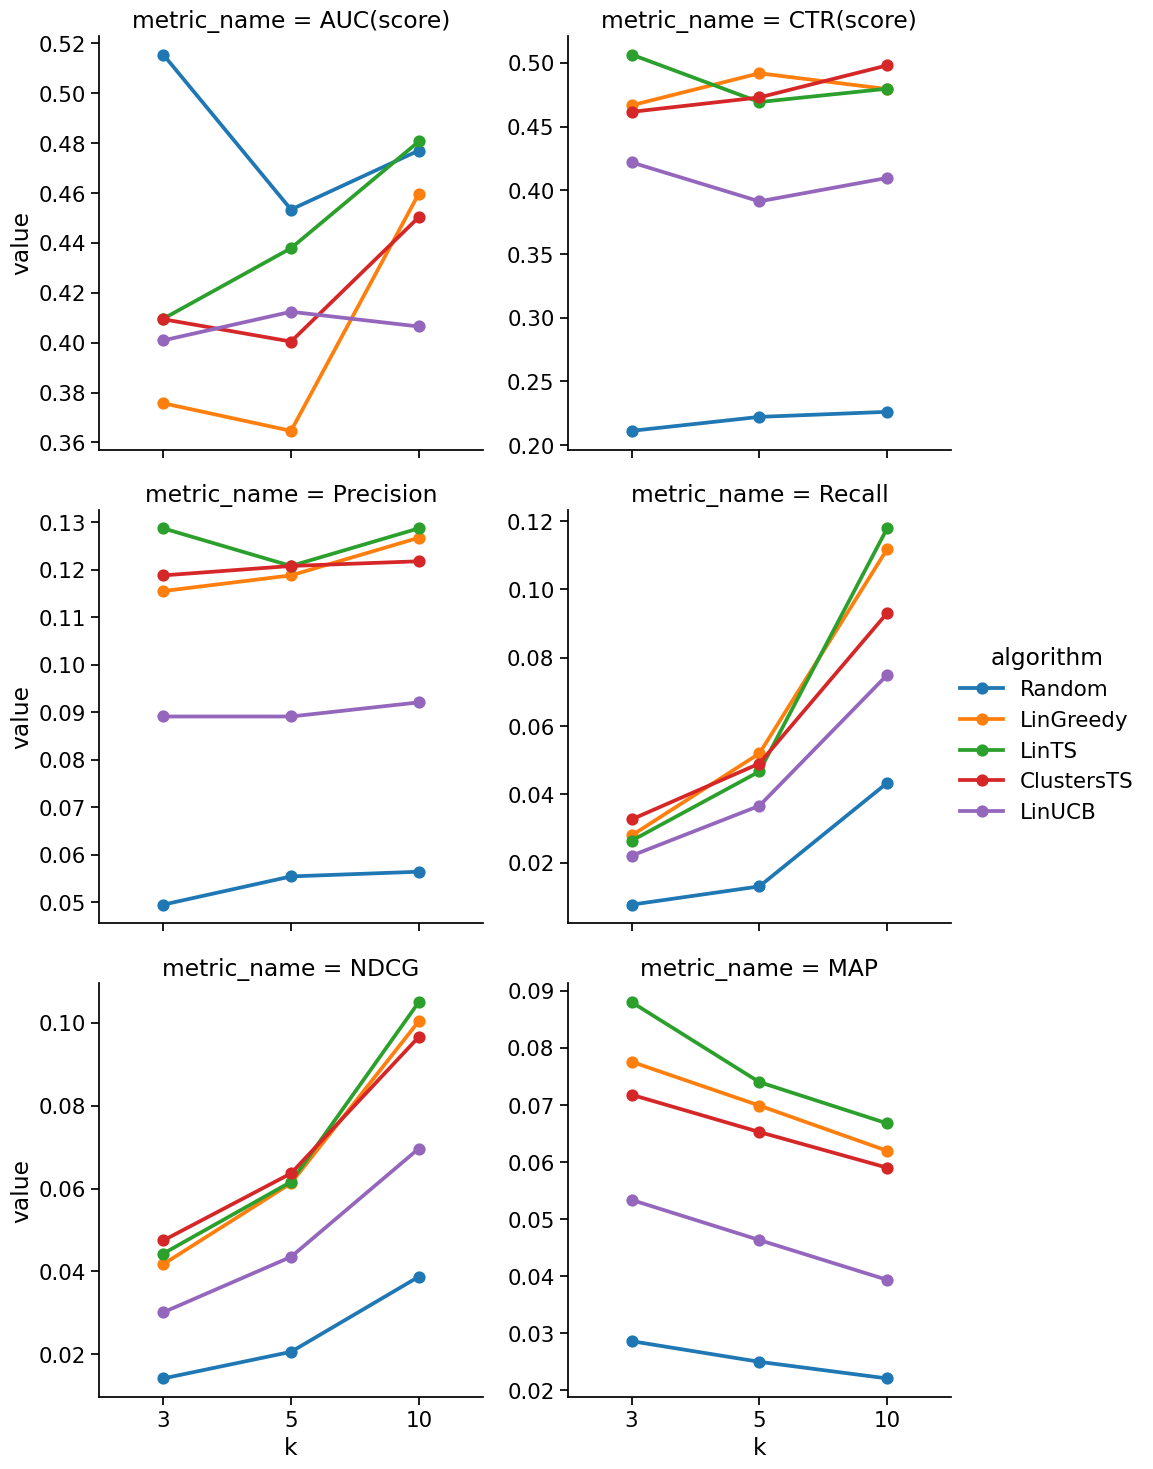

In [6]:
from mab2rec.visualization import plot_metrics_at_k

# Plot each metric across all algorithms at different k
plot_metrics_at_k(reco_to_metrics, col_wrap=2)